<a href="https://colab.research.google.com/github/Poonge1598/CycleGAN/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_cyclegan_dataset.sh?raw=true

--2024-02-18 10:41:47--  https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_cyclegan_dataset.sh?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/raw/master/datasets/download_cyclegan_dataset.sh [following]
--2024-02-18 10:41:48--  https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/raw/master/datasets/download_cyclegan_dataset.sh
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/junyanz/pytorch-CycleGAN-and-pix2pix/master/datasets/download_cyclegan_dataset.sh [following]
--2024-02-18 10:41:48--  https://raw.githubusercontent.com/junyanz/pytorch-CycleGAN-and-pix2pix/master/datasets/download_cyclegan_dataset.sh
Resolving raw.githubusercontent.com (raw.githubuserco

In [ ]:
!mkdir datasets
!bash ./download_cyclegan_dataset.sh?raw=true apple2orange

Specified [apple2orange]
for details.

--2024-02-18 10:42:07--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: './datasets/apple2orange.zip'

./datasets/apple2or 100%[===================>]  74.82M  2.29MB/s    in 23s     

2024-02-18 10:42:30 (3.23 MB/s) - './datasets/apple2orange.zip' saved [78456409/78456409]

Archive:  ./datasets/apple2orange.zip
   creating: ./datasets/apple2orange/trainA/
  inflating: ./datasets/apple2orange/trainA/n07740461_6908.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_7635.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_586.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_9813.jpg  
  inflating: ./datasets/apple2o

### Dataset creation

In [ ]:
import torch
import torch.utils.data as data
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import clear_output

In [ ]:
# Dataset class to load the images

class GeneratorDataset(data.Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform=transform
        self.image_files=np.array([f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir,f))])

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.image_files[idx])
        image=Image.open(img_name).convert('RGB')

        if self.transform:
            image=self.transform(image)

        return image


In [ ]:
# transformation for train and test data

preprocess_train_transformation=transforms.Compose([transforms.Resize(128),
                                                transforms.RandomHorizontalFlip(p=0.5),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


preprocess_test_transformation=transforms.Compose([transforms.Resize(128),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])



In [ ]:
import os

In [ ]:
dataset_path="/kaggle/working/datasets/apple2orange"

In [ ]:
# Define the datasets

train_data_X=GeneratorDataset(root_dir=os.path.join(dataset_path,'trainA'),transform=preprocess_train_transformation)
train_data_Y=GeneratorDataset(root_dir=os.path.join(dataset_path,'trainB'),transform=preprocess_train_transformation)
test_data_X=GeneratorDataset(root_dir=os.path.join(dataset_path,'testA'),transform=preprocess_test_transformation)
test_data_Y=GeneratorDataset(root_dir=os.path.join(dataset_path,'testB'),transform=preprocess_test_transformation)




In [ ]:
print("Found {} images in {}".format(len(train_data_X), 'trainA'))
print("Found {} images in {}".format(len(train_data_Y), 'trainB'))
print("Found {} images in {}".format(len(test_data_X), 'testA'))
print("Found {} images in {}".format(len(test_data_Y), 'testB'))

Found 995 images in trainA
Found 1019 images in trainB
Found 266 images in testA
Found 248 images in testB


To speed up training, we use subset of training data

In [ ]:
from torch.utils.data import Subset
import random

In [ ]:
random.seed(2)

image_to_sample=400

indices_X=random.sample(range(len(train_data_X)),image_to_sample)
indices_Y=random.sample(range(len(train_data_Y)),image_to_sample)

train_data_X=Subset(train_data_X,indices_X)
train_data_Y=Subset(train_data_Y,indices_Y)

### Define the Generator and Discriminator models

In [ ]:
# RESNET

# Residual block
class Residualblock(nn.Module):
    def __init__(self,in_features):
        super(Residualblock,self).__init__()

        self.block=nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_features,in_features,3),
        nn.InstanceNorm2d(in_features),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_features,in_features,3),
        nn.InstanceNorm2d(in_features))

    def forward(self,x):
        return x+self.block(x)


In [ ]:
# Generator class

class Generator(nn.Module):
    def __init__(self,input_channel,n_blocks,filters,output_channel):
        super(Generator,self).__init__()

        #Initial convolution block

        model=[nn.ReflectionPad2d(input_channel),
              nn.Conv2d(input_channel,filters,7),
              nn.InstanceNorm2d(filters),
              nn.ReLU(inplace=True),]

        in_features=filters

        #Downsampling
        for _ in range(2):
            filters*=2
            model+=[
                nn.Conv2d(in_features,filters,3,stride=2,padding=1),
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True)
            ]
            in_features=filters

        #Residual block
        for _ in range(n_blocks):
            model += [Residualblock(filters)]

        #Upsampling
        for _ in range(2):
            filters//=2
            model+=[nn.Upsample(scale_factor=2),
                    nn.Conv2d(in_features, filters, 3, stride=1, padding=1),
                    nn.InstanceNorm2d(filters),
                    nn.ReLU(inplace=True),
                   ]
            in_features=filters



        model += [nn.ReflectionPad2d(output_channel), nn.Conv2d(filters, output_channel, 7), nn.Tanh()]

        self.model=nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)



In [ ]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self,input_channel,filters):
        super(Discriminator,self).__init__()

        def discriminator_block(in_filter,out_filter,normalize=True):
            layer=[nn.Conv2d(in_filter,out_filter,4,stride=2,padding=1)]
            if normalize:
                layer.append(nn.InstanceNorm2d(out_filter))
            layer.append(nn.LeakyReLU(0.2,inplace=True))
            return layer

        self.model=nn.Sequential(*discriminator_block(input_channel,filters,normalize=False),
                                *discriminator_block(filters,filters*2),
                                *discriminator_block(filters*2,filters*4),
                                *discriminator_block(filters*4,filters*8),
                                nn.ZeroPad2d((1,0,1,0)),                                 #Asymmetric padding only to left to top edges
                                nn.Conv2d(filters*8,1,4,padding=1))

    def forward(self,img):
        return self.model(img)






In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
#Instantiating the generator models

G_XtoY=Generator(input_channel=3,n_blocks=9,filters=64,output_channel=3).to(device)
G_YtoX=Generator(input_channel=3,n_blocks=9,filters=64,output_channel=3).to(device)

In [ ]:
#Instantiating the discriminator models

Dx=Discriminator(input_channel=3,filters=64).to(device)
Dy=Discriminator(input_channel=3,filters=64).to(device)

In [ ]:
# Intialize weights from normal distribution for the convilution layers in Generator and discriminator

# Normal distribution (mean=0.0,std=0.02) and bias =0.0

def weights_init_normal(m):
    classname=m.__class__.__name__

    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,mean=0.0,std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data,0.0)


In [ ]:
G_XtoY.apply(weights_init_normal)
G_YtoX.apply(weights_init_normal)
Dx.apply(weights_init_normal)
Dy.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

### Training

In [ ]:
epochs=30
save_eery_epoch=5
lr=0.0002
BETAS=(0.5,0.999)

In [ ]:
# Define dataloaders

train_loader_X=data.DataLoader(train_data_X,batch_size=10,shuffle=True,num_workers=4)
train_loader_Y=data.DataLoader(train_data_Y,batch_size=10,shuffle=True,num_workers=4)
test_loader_X=data.DataLoader(test_data_X,batch_size=10,shuffle=False,num_workers=4)
test_loader_Y=data.DataLoader(test_data_Y,batch_size=10,shuffle=False,num_workers=4)

In [ ]:
# Defining the optimizer and schedulers


# Creating optimizers for the two generators and two discriminators
G_XtoY_optimizer=optim.Adam(G_XtoY.parameters(),lr=lr,betas=BETAS)
G_YtoX_optimizer=optim.Adam(G_YtoX.parameters(),lr=lr,betas=BETAS)
Dx_optimizer=optim.Adam(Dx.parameters(), lr=lr, betas=BETAS)
Dy_optimizer=optim.Adam(Dy.parameters(), lr=lr, betas=BETAS)


In [ ]:
# Time to implement the loss functions used in CycleGAN


SOFT_FAKE_LABEL_RANGE =  [0.0, 0.3] # The label of fake label will be generated within this range.
SOFT_REAL_LABEL_RANGE = [0.7, 1.2] # The label of real label will be generated within this range.


The discriminator loss is defined by:
\begin{equation}
\mathcal{L}_{D} = \frac{1}{2} (\mathbb{E}_{y \sim p_{data}(y)}[(D_Y(y) - r_2)^2] + \mathbb{E}_{x \sim p_{data}(x)}[(D_Y(G_{XY}(x))-r_1)^2]) + \frac{1}{2} (\mathbb{E}_{x \sim p_{data}(x)}[(D_X(x) - r_2)^2] + \mathbb{E}_{y \sim p_{data}(y)}[(D_X(G_{YX}(y))-r_1)^2])
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, $D_X$ and $D_Y$ the two discriminators, and $r_1$ and $r_2$ being the soft fake and real labels chosen from a uniform distribution within the ranges $[0.0, 0.3]$ and $[0.7, 1.2]$ respectively.

In [ ]:
def discriminator_loss(real_image,generated_image,discriminator):
    real_label=torch.empty_like(discriminator(real_image)).uniform_(*SOFT_REAL_LABEL_RANGE)
    fake_label=torch.empty_like(discriminator(generated_image)).uniform_(*SOFT_FAKE_LABEL_RANGE)

    real_loss=nn.MSELoss()(discriminator(real_image),real_label)
    fake_loss=nn.MSELoss()(discriminator(generated_image.detach()),fake_label)

    return (real_loss+fake_loss)/2



The generator loss is defined by:
\begin{equation}
\mathcal{L}_{G} = \mathbb{E}_{x \sim p_{data}(x)}(D_Y(G_{XY}(x)) - r_2)^2 + \mathbb{E}_{y \sim p_{data}(y)}(D_X(G_{YX}(y)) - r_2)^2
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, $D_X$ and $D_Y$ the two discriminators, and $r_2$ being the soft real label chosen from a uniform distribution within the range $[0.7, 1.2]$.

In [ ]:
def generator_loss(generated_image,discriminator):
    real_label=torch.empty_like(discriminator(generated_image)).uniform_(*SOFT_REAL_LABEL_RANGE)

    loss=nn.MSELoss()(discriminator(generated_image),real_label)

    return loss

#### We will be defining two more losses which are specific to CycleGAN compared to classical GAN. i.e. Identity loss and Cycle consistency loss

The cycle consistency loss is defined by:
\begin{equation}
\mathcal{L}_{cyc} = \lambda\mathbb{E}_{x \sim p_{data}(x)}[||x - G_{YX}(G_{XY}(x))||_1] + \lambda\mathbb{E}_{y \sim p_{data}(y)}[||y - G_{XY}(G_{YX}(y))||_1]
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators and $\lambda$ being the weight for the cycle consistency loss.

In [ ]:
LAMBDA =10

In [ ]:
def cycle_consistency_loss(real_image,cycled_image):
    loss=nn.L1Loss()(real_image,cycled_image)

    total_loss=LAMBDA*loss

    return total_loss


The identity loss is defined by:
\begin{equation}
\mathcal{L}_{id} = \frac{1}{2}\lambda\mathbb{E}_{x \sim p_{data}(x)}[||G_{YX}(x) - x||_1] + \frac{1}{2}\lambda\mathbb{E}_{y \sim p_{data}(y)}[||G_{XY}(y) - y||_1]
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, and $\lambda$ being the weight for the identity loss.

In [ ]:
def identity_loss(real_image,generated_image):
    loss=nn.L1Loss()(real_image,generated_image)

    total_loss=0.5*LAMBDA*loss

    return total_loss

The total generator loss is defined by:
\begin{equation}
\mathcal{L}_{G_{tot}} = \mathcal{L}_{G} + \mathcal{L}_{cyc} + \mathcal{L}_{id}
\end{equation}
with $\mathcal{L}_{G_X}$ and $\mathcal{L}_{G_Y}$ being the generator loss for the two domains, $\mathcal{L}_{cyc}$ being the cycle consistency loss and $\mathcal{L}_{id}$ being the identity loss.

#### Setting the checkpoint path for saving the model

In [ ]:
checkpoint_path = os.path.join("checkpoints", 'pytorch', dataset_path, )

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

def save_training_checkpoint(epoch):
    state_dict = {
    'G_XtoY':G_XtoY.state_dict(),
    'G_YtoX':G_YtoX.state_dict(),
    'Dx':Dx.state_dict(),
    'Dy':Dy.state_dict(),
    'G_XtoY_optimizer':G_XtoY_optimizer.state_dict(),
    'G_YtoX_optimizer':G_YtoX_optimizer.state_dict(),
    'Dx_optimizer':Dx_optimizer.state_dict(),
    'Dy_optimizer':Dy_optimizer.state_dict(),
    'epoch': epoch
    }

    save_path = os.path.join(checkpoint_path, 'training-checkpoint')
    torch.save(state_dict, save_path)

# if a checkpoint exists, restore the latest checkpoint.
if os.path.isfile(os.path.join(checkpoint_path, 'training-checkpoint')):
    checkpoint = torch.load(os.path.join(checkpoint_path, 'training-checkpoint'))
    G_XtoY.load_state_dict(checkpoint['G_XtoY'])
    G_YtoX.load_state_dict(checkpoint['G_YtoX'])
    Dx.load_state_dict(checkpoint['Dx'])
    Dy.load_state_dict(checkpoint['Dy'])
    G_XtoY_optimizer.load_state_dict(checkpoint['G_XtoY_optimizer'])
    G_YtoX_optimizer.load_state_dict(checkpoint['G_YtoX_optimizer'])
    Dx_optimizer.load_state_dict(checkpoint['Dx_optimizer'])
    Dy_optimizer.load_state_dict(checkpoint['Dy_optimizer'])
    CURRENT_EPOCH = checkpoint['epoch']
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 5 restored!!


#### Define a function to generate given test input image using a trained generator

In [ ]:
def generate_image(model,test_input):
    model.eval()

    test_input.to(device)

    with torch.no_grad():
        generated_image=model(test_input)

    return generated_image

In [ ]:
batch_size=10

In [ ]:
#Picking samples from domain X and domain Y to visualize how each epoch run changes the pictures
id_sample_X = np.where(test_data_X.image_files == "n07740461_11391.jpg")[0][0]
id_sample_Y = np.where(test_data_Y.image_files == "n07749192_10081.jpg")[0][0]

sample_X = test_data_X[id_sample_X]
sample_Y = test_data_Y[id_sample_Y]

In [ ]:
# functions used to visualize the image
def denormalize(images, std=0.5, mean=0.5):
    # For plot
    images = (images * std) + mean
    return images

def deprocess(input_tensor):
    if len(input_tensor.shape) == 3:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (1, 2, 0))
    elif len(input_tensor.shape) == 4:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (0, 2, 3, 1))

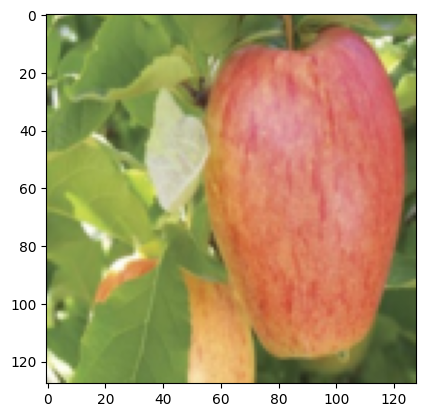

In [ ]:
plt.imshow(deprocess(sample_X))

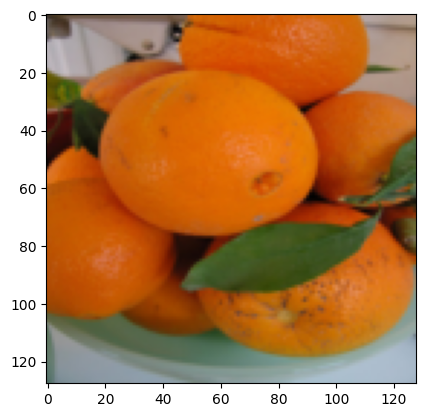

In [ ]:
plt.imshow(deprocess(sample_Y))

Epoch: 30, G_XtoY_loss: 2.4428, G_YtoX_loss: 2.3598, Dx_loss: 0.1156, Dy_loss: 0.1144
Time taken for epoch 30 is 59.77 sec



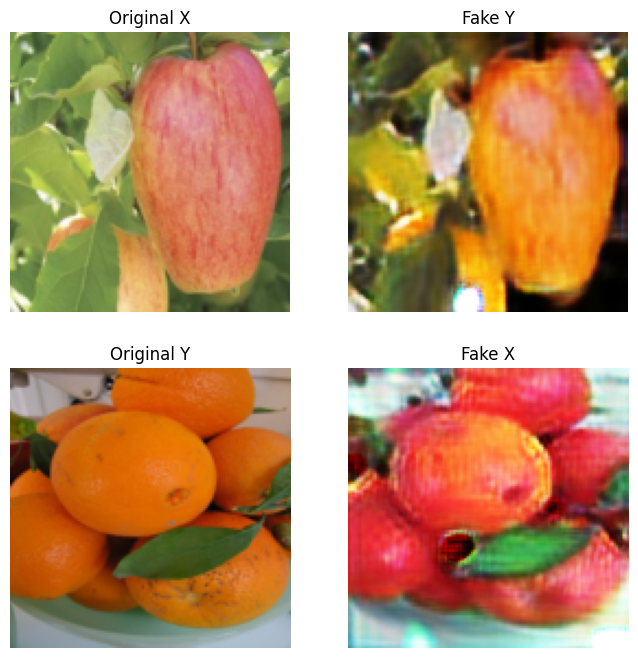

Saving checkpoint for epoch 30 at /kaggle/working/datasets/apple2orange
Time taken for epoch 30 is 61.08014249801636 sec



In [ ]:
# Training process

import time
from tqdm import tqdm
import gc

training_steps=np.ceil((min(len(train_data_X),len(train_data_Y))/10)).astype(int)

torch.autograd.set_detect_anomaly(True)

for epoch in range(1,epochs+1):
    start_time = time.time()
    print('Start of epoch %d' % (epoch,))
    train_iter_loader_X=iter(train_loader_X)
    train_iter_loader_Y=iter(train_loader_Y)

    # Initialize losses
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    Dx_loss_mean = 0
    Dy_loss_mean = 0

    for step in range(training_steps):

        real_image_X=next(train_iter_loader_X).to(device)
        real_image_Y=next(train_iter_loader_Y).to(device)

        #Discriminator loss

        fake_image_X=G_YtoX(real_image_Y).detach()

        fake_image_Y=G_XtoY(real_image_X).detach()

        Dx_loss=discriminator_loss(real_image_X,fake_image_X,Dx)

        Dy_loss=discriminator_loss(real_image_Y,fake_image_Y,Dy)

        #Update discriminators
        Dx_optimizer.zero_grad()
        Dx_loss.backward()
        Dx_optimizer.step()

        Dy_optimizer.zero_grad()
        Dy_loss.backward()
        Dy_optimizer.step()



        # Generator loss

        fake_image_X = G_YtoX(real_image_Y)
        fake_image_Y = G_XtoY(real_image_X)

        G_XtoYloss=generator_loss(fake_image_Y,Dy)
        G_YtoXloss=generator_loss(fake_image_X,Dx)

        # Cycle consistency loss

        cycled_X=G_YtoX(fake_image_Y)
        cycled_Y=G_XtoY(fake_image_X)


        cycle_loss_X=cycle_consistency_loss(real_image_X,cycled_X)
        cycle_loss_Y=cycle_consistency_loss(real_image_Y,cycled_Y)


        #Identity loss

        identity_loss_X=identity_loss(real_image_X,G_YtoX(real_image_X))
        identity_loss_Y=identity_loss(real_image_Y,G_XtoY(real_image_Y))

        # Total loss
        total_G_XtoYloss=G_XtoYloss+cycle_loss_Y+identity_loss_Y
        total_G_YtoXloss=G_YtoXloss+cycle_loss_X+identity_loss_X

        #update generators

        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()
        total_G_XtoYloss.backward(retain_graph=True)
        total_G_YtoXloss.backward()
        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()

        #Adding losses

        G_XtoY_loss_mean += total_G_XtoYloss.item()
        G_YtoX_loss_mean += total_G_YtoXloss.item()
        Dx_loss_mean += Dx_loss.item()
        Dy_loss_mean += Dy_loss.item()

        if step % 10 == 0:
            print ('.', end='')

    clear_output(wait=True)
    # Calculate mean losses
    G_XtoY_loss_mean /= training_steps
    G_YtoX_loss_mean /= training_steps
    Dx_loss_mean /= training_steps
    Dy_loss_mean /= training_steps

    # Output loss values for epoch
    print(f'Epoch: {epoch}, G_XtoY_loss: {G_XtoY_loss_mean:.4f}, G_YtoX_loss: {G_YtoX_loss_mean:.4f}, Dx_loss: {Dx_loss_mean:.4f}, Dy_loss: {Dy_loss_mean:.4f}')

    # Additional steps for visualization, checkpoint saving, etc., go here

    print(f'Time taken for epoch {epoch} is {time.time() - start_time:.2f} sec\n')

    sample_X_tensor = sample_X.unsqueeze(0).to(device)  # Adding batch dimension
    sample_Y_tensor = sample_Y.unsqueeze(0).to(device)  # Adding batch dimension



    # Generate the fake samples using the generate_images function
    fake_sample_Y = generate_image(G_XtoY, sample_X_tensor)
    fake_sample_X = generate_image(G_YtoX, sample_Y_tensor)

    # Convert the images to numpy for visualization using deprocess
    sample_X_np = deprocess(sample_X_tensor).squeeze(0).numpy()
    sample_Y_np = deprocess(sample_Y_tensor).squeeze(0).numpy()
    fake_sample_Y_np = deprocess(fake_sample_Y).squeeze(0).numpy()
    fake_sample_X_np = deprocess(fake_sample_X).squeeze(0).numpy()

    #print(f'real image shape x:{sample_X_tensor.shape}')
    #print(f'real image shape y:{sample_Y_tensor.shape}')
    #print(f'fake Y shape:{fake_sample_Y.shape}')
    #print(f'fake X shape:{fake_sample_X.shape}')

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.subplot(221)
    plt.title("Original X")
    plt.imshow(sample_X_np)
    plt.axis('off')

    plt.subplot(222)
    plt.title("Fake Y")
    plt.imshow(fake_sample_Y_np)
    plt.axis('off')

    plt.subplot(223)
    plt.title("Original Y")
    plt.imshow(sample_Y_np)
    plt.axis('off')

    plt.subplot(224)
    plt.title("Fake X")
    plt.imshow(fake_sample_X_np)
    plt.axis('off')

    plt.show()
    # Re-enable training mode
    G_XtoY.train()
    G_YtoX.train()




    # Save the checkpoint for every SAVE_EVERY_N_EPOCH epoch

    if epoch % 5 == 0:

      save_training_checkpoint(epoch)


      print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             checkpoint_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start_time))
    gc.collect()


In [ ]:
def save_model(model, optimizer, epoch, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, filename)

# Example of saving the models
save_model(G_XtoY, G_XtoY_optimizer, epoch, 'G_XtoY_model.pth')
save_model(G_YtoX, G_YtoX_optimizer, epoch, 'G_YtoX_model.pth')
save_model(Dx, Dx_optimizer, epoch, 'Dx_model.pth')
save_model(Dy, Dy_optimizer, epoch, 'Dy_model.pth')

In [ ]:
"""
#To load the models(if in case)
def load_model(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

#To load the models
load_model(G_XtoY, G_XtoY_optimizer, 'G_XtoY_model.pth')
load_model(G_YtoX, G_YtoX_optimizer, 'G_YtoX_model.pth')
load_model(Dx, Dx_optimizer, 'Dx_model.pth')
load_model(Dy, Dy_optimizer, 'Dy_model.pth')

"""

"\n#To load the models(if in case)\ndef load_model(model, optimizer, filename):\n    checkpoint = torch.load(filename)\n    model.load_state_dict(checkpoint['model_state_dict'])\n    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])\n    epoch = checkpoint['epoch']\n\n#To load the models\nload_model(G_XtoY, G_XtoY_optimizer, 'G_XtoY_model.pth')\nload_model(G_YtoX, G_YtoX_optimizer, 'G_YtoX_model.pth')\nload_model(Dx, Dx_optimizer, 'Dx_model.pth')\nload_model(Dy, Dy_optimizer, 'Dy_model.pth')\n\n"

#### Testing: Displaying the orginal X(apple set) with it's fake version derived from domain Y(orange set)

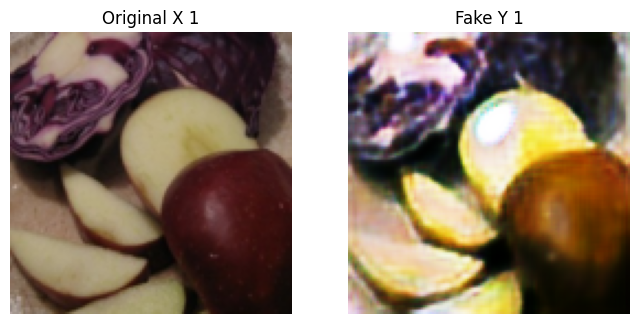

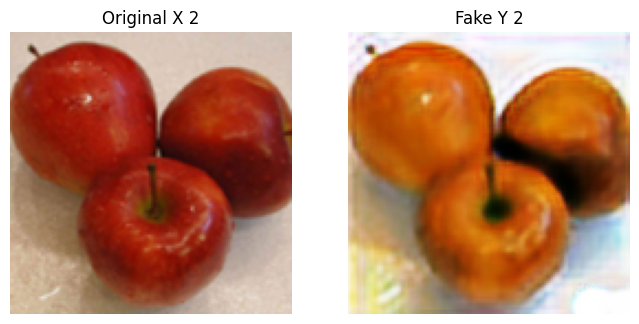

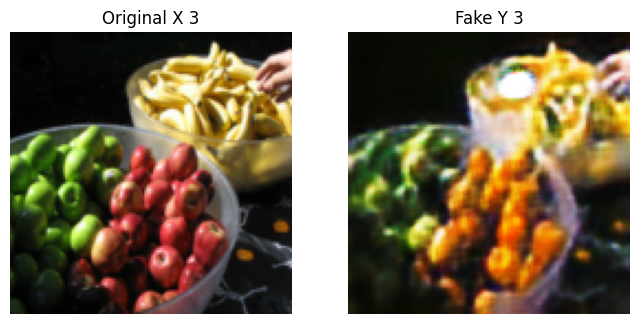

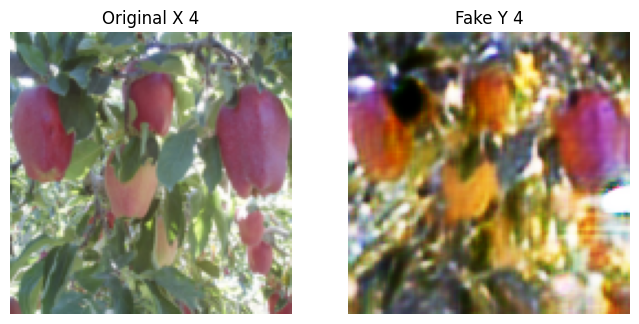

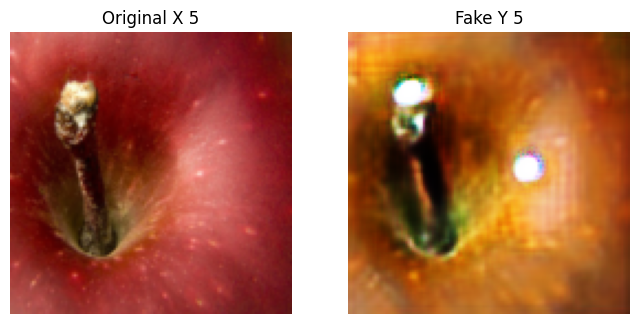

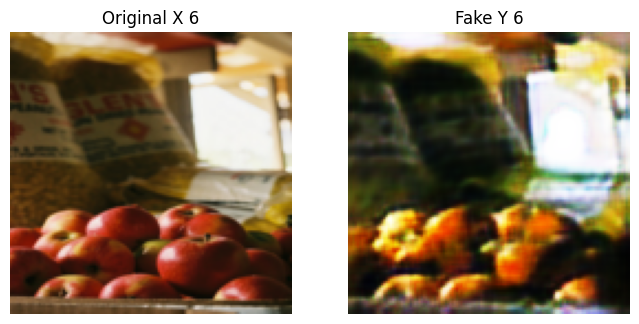

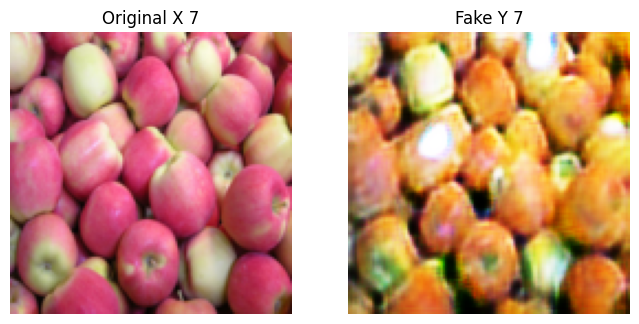

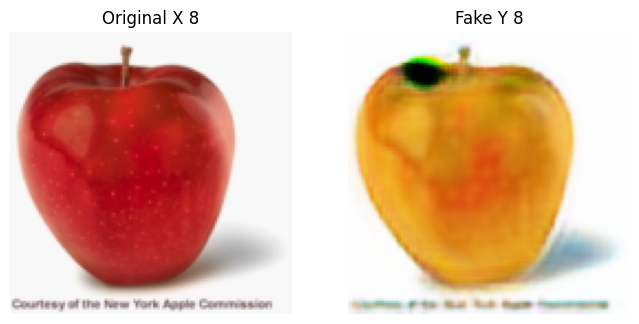

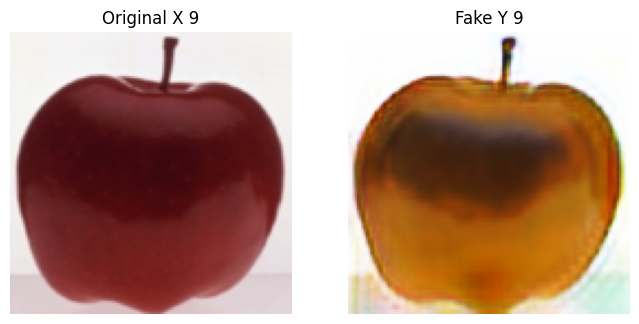

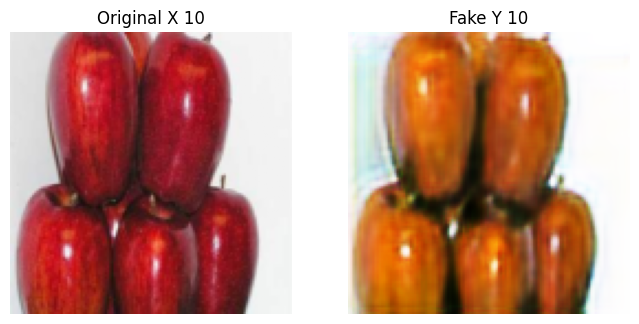

In [ ]:
# Assuming 'generate_images' function is defined elsewhere and
# 'deprocess' handles a single image tensor properly

for batch_num, images in enumerate(test_loader_X):
  # Process each image in the batch individually
  for i in range(images.size(0)):  # images.size(0) is the batch size
      single_image = images[i]  # Get the i-th image in the batch
      fake_sample_Y = generate_image(G_XtoY, single_image.unsqueeze(0).to(device))

      # Deprocess the single image
      sample_X_np = deprocess(single_image).numpy()
      fake_sample_Y_np = deprocess(fake_sample_Y.squeeze()).numpy()

      # Plot the original and fake images
      plt.figure(figsize=(8, 4))
      plt.subplot(121)
      plt.title(f"Original X {i+1}")
      plt.imshow(sample_X_np)
      plt.axis('off')

      plt.subplot(122)
      plt.title(f"Fake Y {i+1}")
      plt.imshow(fake_sample_Y_np)
      plt.axis('off')

      plt.show()

  # Break after the first batch for demonstration purposes
  # Remove the break statement below to process all batches
  break


#### Similarly, displaying the orginal Y(orange set) with it's fake version derived from domain X(apple set)

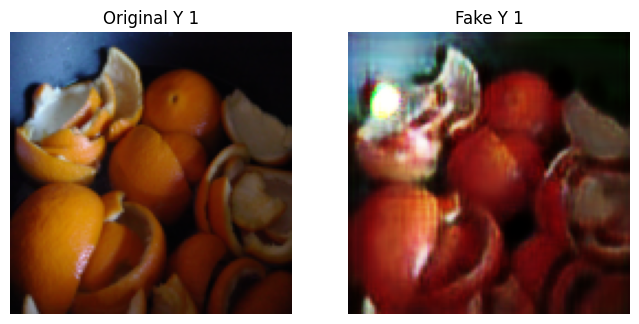

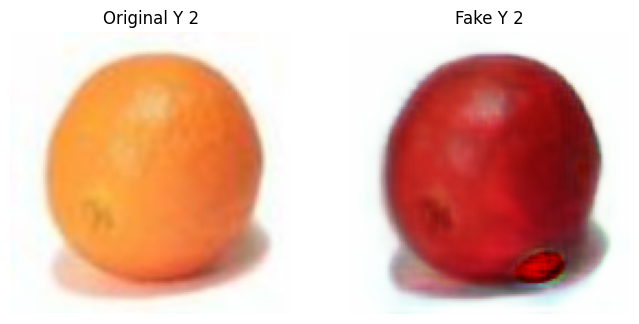

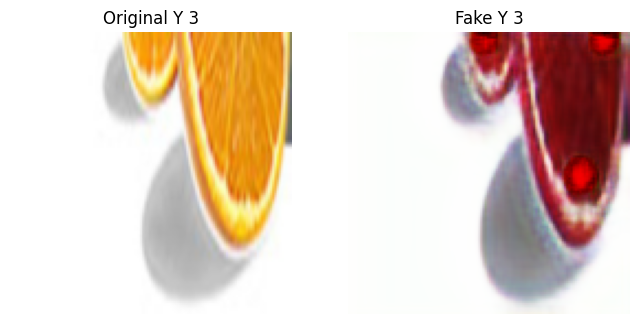

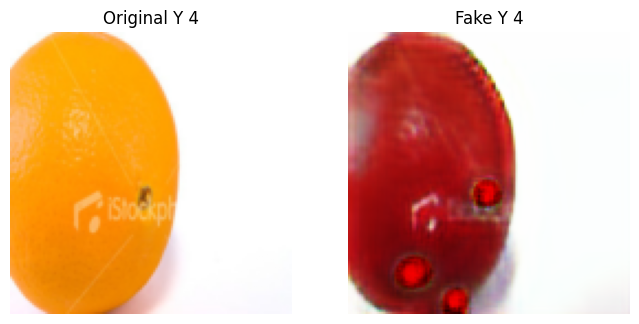

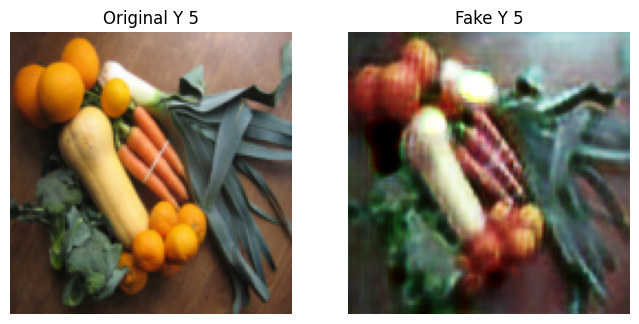

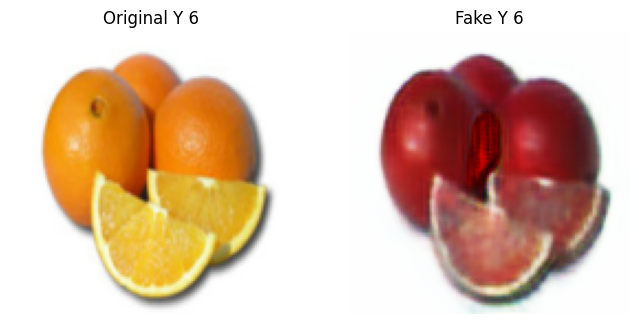

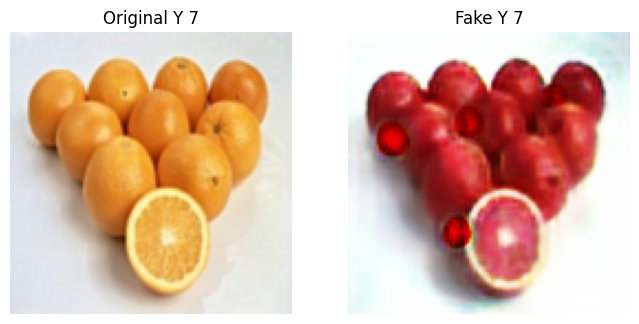

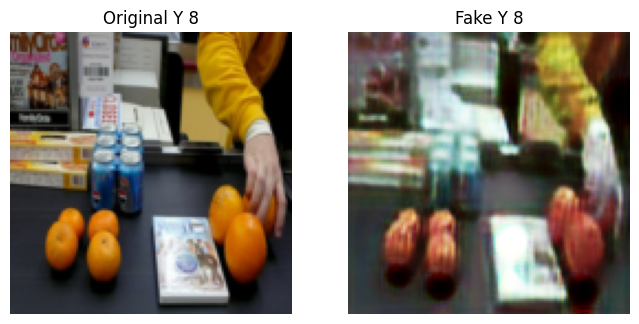

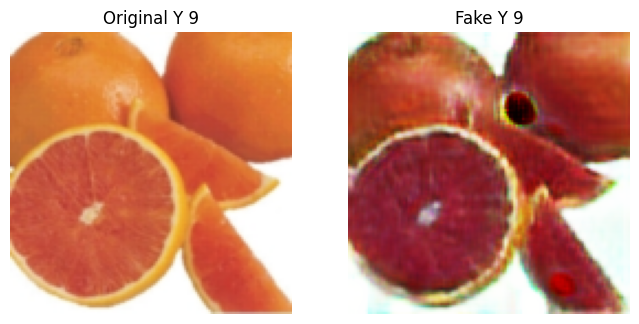

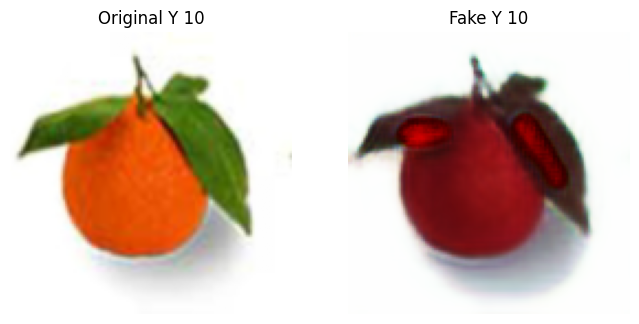

In [ ]:
# Assuming 'generate_images' function is defined elsewhere and
# 'deprocess' handles a single image tensor properly

for batch_num, images in enumerate(test_loader_Y):
  # Process each image in the batch individually
  for i in range(images.size(0)):  # images.size(0) is the batch size
      single_image = images[i]  # Get the i-th image in the batch
      fake_sample_X = generate_image(G_YtoX, single_image.unsqueeze(0).to(device))

      # Deprocess the single image
      sample_Y_np = deprocess(single_image).numpy()
      fake_sample_X_np = deprocess(fake_sample_X.squeeze()).numpy()

      # Plot the original and fake images
      plt.figure(figsize=(8, 4))
      plt.subplot(121)
      plt.title(f"Original Y {i+1}")
      plt.imshow(sample_Y_np)
      plt.axis('off')

      plt.subplot(122)
      plt.title(f"Fake Y {i+1}")
      plt.imshow(fake_sample_X_np)
      plt.axis('off')

      plt.show()

  # Break after the first batch for demonstration purposes
  # Remove the break statement below to process all batches
  break


### Observations
- The "Fake Y" image exhibits color changes towards the target domain but lacks sharpness and detail.
- The structure of the original apple is maintained, indicating good domain translation while preserving content.

### Anomalies
- **Blurriness**: The generated image does not have the same level of detail as the original, resulting in a blurry appearance.
- **Artifacts**: There are some unnatural patterns which may suggest the generator struggles with certain textures or edges.

### Recommendations
1. **Fine-tune Training**: Adjust learning rates and prolong training to give the generator more time to learn.
2. **Incorporate Advanced Losses**: Use perceptual loss to focus on feature similarities between the domains.
3. **Increase Data Quality**: Train with higher-resolution images to encourage the model to generate crisper details.
4. **Hyperparameter Optimization**: Systematically search for better hyperparameters to balance the training of the generator and discriminator.
